In [1]:
import pandas as pd
import numpy as np
base = pd.read_csv('/data/zhangyue/pygaggle/data/msmarco_ans_entire/run.bm25.dev.small.tsv', sep="\t", 
                  names=['qid','pid','rank'],
                  usecols=['qid', 'pid','rank'])
base['score'] = 1/base['rank']

dev_qrel = pd.read_csv('../collections/msmarco-passage/qrels.dev.small.tsv', sep="\t",
                       names=["qid", "q0", "pid", "rel"], 
                       usecols=['qid', 'pid', 'rel'])

base = base.merge(dev_qrel, left_on=['qid', 'pid'], right_on=['qid', 'pid'], how='left')                                                                                                           
base['rel'] = base['rel'].fillna(0)                                                                                                                                             
base = base.sort_values(['qid','pid']).set_index(['qid','pid'])
base.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 6974598 entries, (2, 55860) to (1102400, 8830447)
Data columns (total 3 columns):
 #   Column  Dtype  
---  ------  -----  
 0   rank    int64  
 1   score   float64
 2   rel     float64
dtypes: float64(2), int64(1)
memory usage: 389.1 MB


In [2]:
import pandas as pd
import numpy as np
rerank = pd.read_csv('run.monobert.ans_entire.dev.trec', sep="\t", 
                  names=['qid','q0','pid','rank','score','tag'],
                  usecols=['qid', 'pid','rank'])
rerank['score'] = 1/rerank['rank']

dev_qrel = pd.read_csv('../collections/msmarco-passage/qrels.dev.small.tsv', sep="\t", 
                       names=["qid", "q0", "pid", "rel"], 
                       usecols=['qid', 'pid', 'rel'])                                                                                      
rerank = rerank.merge(dev_qrel, left_on=['qid', 'pid'], right_on=['qid', 'pid'], how='left')                                                                                                           
rerank['rel'] = rerank['rel'].fillna(0)                                                                                                                                            
rerank = rerank.sort_values(['qid','pid']).set_index(['qid','pid'])
rerank.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 6974598 entries, (2, 55860) to (1102400, 8830447)
Data columns (total 3 columns):
 #   Column  Dtype  
---  ------  -----  
 0   rank    int64  
 1   score   float64
 2   rel     float64
dtypes: float64(2), int64(1)
memory usage: 389.1 MB


In [3]:
from tqdm import tqdm
def eval_mrr(dev_data):                                                                                                                                                                                  
    score_tie_counter = 0                                                                                                                                                                                
    score_tie_query = set()                                                                                                                                                                              
    MRR = []                                                                                                                                                                                             
    for qid, group in tqdm(dev_data.groupby('qid')):                                                                                                                                                     
        group = group.reset_index()                                                                                                                                                                      
        rank = 0                                                                                                                                                                                         
        prev_score = None                                                                                                                                                                                
        assert len(group['pid'].tolist()) == len(set(group['pid'].tolist()))                                                                                                                             
        # stable sort is also used in LightGBM                                                                                                                                                           
                                                                                                                                                                                                         
        for t in group.sort_values('score', ascending=False, kind='mergesort').itertuples():                                                                                                             
            if prev_score is not None and abs(t.score - prev_score) < 1e-8:                                                                                                                              
                score_tie_counter += 1                                                                                                                                                                   
                score_tie_query.add(qid)                                                                                                                                                                 
            prev_score = t.score                                                                                                                                                                         
            prev_pid = t.pid                                                                                                                                                                             
            rank += 1                                                                                                                                                                                    
            if t.rel>0:                                                                                                                                                                                  
                MRR.append(1.0/rank)                                                                                                                                                                     
                break                                                                                                                                                                                    
            elif rank == 10 or rank == len(group):
                MRR.append(0.)
                break

    score_tie = f'score_tie occurs {score_tie_counter} times in {len(score_tie_query)} queries'
    mrr_10 = np.mean(MRR).item()
    return {'score_tie': score_tie, 'mrr_10': mrr_10}

In [4]:
eval_mrr(base)

100%|██████████| 6980/6980 [00:13<00:00, 511.99it/s]


{'score_tie': 'score_tie occurs 0 times in 0 queries',
 'mrr_10': 0.1873645222176741}

In [5]:
eval_mrr(rerank)

100%|██████████| 6980/6980 [00:13<00:00, 511.47it/s]


{'score_tie': 'score_tie occurs 0 times in 0 queries',
 'mrr_10': 0.3792195956701687}

In [6]:
merge = base.join(rerank,how='left',lsuffix='base',rsuffix='rerank')
merge = merge.rename(columns={"relbase": "rel"})
del merge['relrerank']
merge.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 6974598 entries, (2, 55860) to (1102400, 8830447)
Data columns (total 5 columns):
 #   Column       Dtype  
---  ------       -----  
 0   rankbase     int64  
 1   scorebase    float64
 2   rel          float64
 3   rankrerank   int64  
 4   scorererank  float64
dtypes: float64(3), int64(2)
memory usage: 815.5 MB


In [7]:
merge.isna().any()

rankbase       False
scorebase      False
rel            False
rankrerank     False
scorererank    False
dtype: bool

In [8]:
def genNewRerank(merge, cutoff=100):
    new_rerank = []
    for qid, group in tqdm(merge.groupby('qid')):                                                                                                                                                     
        group = group.reset_index()                                                                                                                                                                      
        rank = 0
        temp = []
        for t in group.sort_values('scorebase', ascending=False, kind='mergesort').itertuples():                                                                                                                                                                                                                                                                                     
            rank += 1
            if rank <= cutoff:
                temp.append((qid, t.pid, t.scorererank, rank, t.rel))
            else:
                break
        new_rerank.extend(sorted(temp, key=lambda x:x[2], reverse=True))
    return pd.DataFrame(new_rerank, 
                        columns=['qid','pid','score','rank','rel']
                       ).set_index(['qid','pid'])

In [9]:
def task(df, i):
    return eval_mrr(genNewRerank(merge, i))

from joblib import Parallel, delayed
task_res = Parallel(n_jobs=20,verbose=10)(delayed(task)(merge, i) for i in list(range(10,1001,10)))
bm25_bert = {}
for i,res in zip(range(10,1001,10),task_res):
    bm25_bert[i] = res

[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   1 tasks      | elapsed:  7.6min
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:  8.9min
[Parallel(n_jobs=20)]: Done  21 tasks      | elapsed: 12.1min
[Parallel(n_jobs=20)]: Done  45 tasks      | elapsed: 16.9min
[Parallel(n_jobs=20)]: Done  58 tasks      | elapsed: 20.9min
[Parallel(n_jobs=20)]: Done  72 out of 100 | elapsed: 25.9min remaining: 10.1min
[Parallel(n_jobs=20)]: Done  83 out of 100 | elapsed: 27.6min remaining:  5.6min
[Parallel(n_jobs=20)]: Done  94 out of 100 | elapsed: 30.2min remaining:  1.9min
[Parallel(n_jobs=20)]: Done 100 out of 100 | elapsed: 31.1min finished


In [10]:
import pandas as pd
import numpy as np
base = pd.read_csv('run.10000.ltr.dev.tsv', sep="\t", 
                  names=['qid','q0','pid','rank','score','tag'],
                  usecols=['qid', 'pid','rank'])
base = base[base['rank']<=1000]
base['score'] = 1/base['rank']

dev_qrel = pd.read_csv('../collections/msmarco-passage/qrels.dev.small.tsv', sep="\t",
                       names=["qid", "q0", "pid", "rel"], 
                       usecols=['qid', 'pid', 'rel'])

base = base.merge(dev_qrel, left_on=['qid', 'pid'], right_on=['qid', 'pid'], how='left')                                                                                                           
base['rel'] = base['rel'].fillna(0)                                                                                                                                             
base = base.sort_values(['qid','pid']).set_index(['qid','pid'])
base.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 6974598 entries, (2, 29510) to (1102400, 8841784)
Data columns (total 3 columns):
 #   Column  Dtype  
---  ------  -----  
 0   rank    int64  
 1   score   float64
 2   rel     float64
dtypes: float64(2), int64(1)
memory usage: 392.1 MB


In [11]:
import pandas as pd
import numpy as np
rerank = pd.read_csv('run.bm25.ltr.bert.1000.tsv', sep="\t", 
                  names=['qid','pid','rank'],
                  usecols=['qid', 'pid','rank'])
rerank['score'] = 1/rerank['rank']

dev_qrel = pd.read_csv('../collections/msmarco-passage/qrels.dev.small.tsv', sep="\t", 
                       names=["qid", "q0", "pid", "rel"], 
                       usecols=['qid', 'pid', 'rel'])                                                                                      
rerank = rerank.merge(dev_qrel, left_on=['qid', 'pid'], right_on=['qid', 'pid'], how='left')                                                                                                           
rerank['rel'] = rerank['rel'].fillna(0)                                                                                                                                            
rerank = rerank.sort_values(['qid','pid']).set_index(['qid','pid'])
rerank.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 6974598 entries, (2, 29510) to (1102400, 8841784)
Data columns (total 3 columns):
 #   Column  Dtype  
---  ------  -----  
 0   rank    int64  
 1   score   float64
 2   rel     float64
dtypes: float64(2), int64(1)
memory usage: 392.1 MB


In [12]:
eval_mrr(base)

100%|██████████| 6980/6980 [00:13<00:00, 514.83it/s]


{'score_tie': 'score_tie occurs 0 times in 0 queries',
 'mrr_10': 0.2520736116796289}

In [13]:
eval_mrr(rerank)

100%|██████████| 6980/6980 [00:13<00:00, 516.02it/s]


{'score_tie': 'score_tie occurs 0 times in 0 queries',
 'mrr_10': 0.38722119889025336}

In [14]:
merge = base.join(rerank,how='left',lsuffix='base',rsuffix='rerank')
merge = merge.rename(columns={"relbase": "rel"})
del merge['relrerank']
merge.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 6974598 entries, (2, 29510) to (1102400, 8841784)
Data columns (total 5 columns):
 #   Column       Dtype  
---  ------       -----  
 0   rankbase     int64  
 1   scorebase    float64
 2   rel          float64
 3   rankrerank   int64  
 4   scorererank  float64
dtypes: float64(3), int64(2)
memory usage: 818.5 MB


In [15]:
merge.isna().any()

rankbase       False
scorebase      False
rel            False
rankrerank     False
scorererank    False
dtype: bool

In [16]:
bm25_ltr_bert = {}
for i in list(range(5,101,5)):
    bm25_ltr_bert[i] = eval_mrr(genNewRerank(merge, i))

100%|██████████| 6980/6980 [00:12<00:00, 566.20it/s]


In [17]:
bm25_bert_N_MRR = [(k,v['mrr_10']) for k,v in bm25_bert.items()]
bm25_ltr_bert_N_MRR = [(k,v['mrr_10']) for k,v in bm25_ltr_bert.items()]
speedup = {k:-1 for k,v in bm25_ltr_bert_N_MRR}
for new, achieve in bm25_ltr_bert_N_MRR:
    for old,target in bm25_bert_N_MRR:
        if achieve>=target:
            speedup[new] = max(speedup[new], old)
speedup

{5: 10,
 10: 30,
 15: 60,
 20: 120,
 25: 180,
 30: 240,
 35: 320,
 40: 350,
 45: 440,
 50: 560,
 55: 580,
 60: 620,
 65: 780,
 70: 830,
 75: 970,
 80: 1000,
 85: 1000,
 90: 1000,
 95: 1000,
 100: 1000}

In [20]:
for new, old in speedup.items():
    new_time = new*0.009566667+0.02333+0.34
    new_mrr = bm25_ltr_bert[new]['mrr_10']
    old_time = old*0.009566667+0.02333+0.015
    old_mrr = bm25_bert[old]['mrr_10']
    print(new, old, new_mrr, old_mrr, new_time, old_time, old_time/new_time)

5 10 0.29171203438395416 0.27583179833537996 0.411163335 0.13399666999999998 0.32589644696796705
10 30 0.3308532883067267 0.32661839950880067 0.45899667 0.32533001 0.7087851203800672
15 60 0.3468207349797608 0.34432693182335017 0.506830005 0.6123300199999999 1.208156608644352
20 120 0.35668031109291853 0.3559470368854323 0.5546633400000001 1.1863300399999999 2.1388290057172332
25 180 0.3625274594078319 0.36245684950197843 0.602496675 1.7603300599999998 2.9217257672002916
30 240 0.36692693409742116 0.3664743371082913 0.65033001 2.33433008 3.589454652415625
35 320 0.3690809910401601 0.3688184495383636 0.698163345 3.09966344 4.4397395855836574
40 350 0.36968526856779005 0.36968253968253967 0.74599668 3.38666345 4.539783541664019
45 440 0.3718483080911448 0.37163181652794836 0.7938300149999999 4.247663479999999 5.350847662266839
50 560 0.3733382225860736 0.3732645426843134 0.8416633499999999 5.3956635199999985 6.410714592716909
55 580 0.3746663937781416 0.3742391526811297 0.889496684999999

In [21]:
mrr_data = {}
speedup_data = {}
for new, old in speedup.items():
    new_time = new*0.009566667+0.02333+0.34
    new_mrr = bm25_ltr_bert[new]['mrr_10']
    old_time = old*0.009566667+0.02333+0.015
    old_mrr = bm25_bert[old]['mrr_10']
    mrr_data[new] = new_mrr
    speedup_data[new] = old_time/new_time

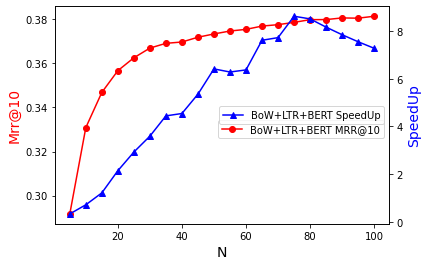

In [23]:
import matplotlib.pyplot as plt

fig,ax = plt.subplots()

# make a plot
ax.plot(mrr_data.keys(), mrr_data.values(), color="red", marker="o",label = 'BoW+LTR+BERT MRR@10')
# set x-axis label
plt.legend(loc='best', bbox_to_anchor=(0.5, 0., 0.5, 0.5))
ax.set_xlabel("N",fontsize=14)
# set y-axis label
ax.set_ylabel("Mrr@10",color="red",fontsize=14)
ax2=ax.twinx()
# make a plot with different y-axis using second axis object
ax2.plot(speedup_data.keys(), speedup_data.values(),color="blue",marker="^",label = 'BoW+LTR+BERT SpeedUp')
ax2.set_ylabel("SpeedUp",color="blue",fontsize=14)
# my_xticks = ['100','200','300','400','500','600','700','800','900','1000']
# x = [0,1,2,3,4,5,6,7,8,9]
# plt.xticks(x, my_xticks)
# plt.hlines(0.86289,0,11, color='g', label = 'bm25+BERT/T5')
plt.legend(loc='right')
plt.show()